<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/master/Pytorch_BSNetConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kornia

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else 
                      ("mps" if torch.backends.mps.is_available() else "cpu"))



In [3]:
!pip install -U spectral
if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

URL transformed to HTTPS due to an HSTS policy
--2023-08-22 19:21:55--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 2001:720:1410::65, 158.227.0.65
Connecting to www.ehu.eus (www.ehu.eus)|2001:720:1410::65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: 'Indian_pines_corrected.mat.11'

Indian_pines_correc 100%[===================>]   5.68M  2.65MB/s    in 2.1s    

2023-08-22 19:21:57 (2.65 MB/s) - 'Indian_pines_corrected.mat.11' saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-08-22 19:21:57--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 2001:720:1410::65, 158.227.0.65
Connecting to www.ehu.eus (www.ehu.eus)|2001:720:1410::65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: 'Indian_pines_gt.mat.11'

Indian_pines_gt.mat 100%[==============

In [4]:
from music_2d_dataset import MUSIC2DDataset
import music_2d_dataset
path2d = "MUSIC2D_HDF5"
path3d = "MUSIC3D_HDF5"
transform = music_2d_dataset.JointTransform2D(crop=(7,7), p_flip=0, color_jitter_params=None, long_mask=True)
data_train = MUSIC2DDataset(
        path2d=path2d, path3d=path3d,
        partition="train", 
        spectrum="fullSpectrum",
        transform=transform, 
        full_dataset=True, 
)
train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

In [5]:
print(data_train[0]["image"].shape)
print(data_train.__len__())

torch.Size([128, 7, 7])
437


In [8]:

class BSNET_Conv(nn.Module):

    def __init__(self,):
      
        super(BSNET_Conv, self).__init__()
        self.conv1 = nn.Sequential(
        	nn.Conv2d(128,64,(3,3),1,0),
        	nn.ReLU(True))

        self.conv1_1 = nn.Sequential(
        	nn.Conv2d(128,128,(3,3),1,0),
        	nn.ReLU(True))
        self.conv1_2 = nn.Sequential(
        	nn.Conv2d(128,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_2 = nn.Sequential(
        	nn.ConvTranspose2d(64,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_1 = nn.Sequential(
        	nn.ConvTranspose2d(64,128,(3,3),1,0),
        	nn.ReLU(True))

        self.conv2_1 = nn.Sequential(
        	nn.Conv2d(128,128,(1,1),1,0),
        	nn.Sigmoid())
        

        self.fc1 = nn.Sequential(
        	nn.Linear(64,128),
        	nn.ReLU(True))
        self.fc2 = nn.Sequential(
        	nn.Linear(128,128),
        	nn.Sigmoid())
        self.gp=nn.AvgPool2d(5)
    
        
    def BAM(self,x):
        
        x = self.conv1(x)
        
        
        x = self.gp(x)
        
        
        x = x.view(-1,64)
        
        x = self.fc1(x)
        
        x = self.fc2(x)
        
        x = x.view(-1,1,1,128)
        x = x.permute(0,3,1,2)
        
        return x

    def RecNet(self,x):

      x = self.conv1_1(x)
      
      x = self.conv1_2(x)
      
      x = self.deconv1_2(x)
      
      x = self.deconv1_1(x)
      
      x = self.conv2_1(x)
      
      return x
      
      

    def forward(self,x):
      
      BRW = self.BAM(x)
      
      x = x*BRW
      ret = self.RecNet(x)
      
      return ret


       
model = BSNET_Conv().to(device)


In [18]:
from torchsummary import summary
summary(model,(128,7,7),batch_size=16)

RuntimeError: Input type (torch.FloatTensor) and weight type (MPSFloatType) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [27]:
top = 30
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), betas=([0.9, 0.999]), lr = 0.1)

In [28]:
import skimage
import kornia
global bsnlist
ssim = kornia.losses.SSIMLoss(5, reduction='none')
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    model.train()
    ENTROPY = torch.zeros(128)

    for batch_idx, data in enumerate(train_loader):
        data = data["image"].to(device)
        optimizer.zero_grad()
        output =  model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,128):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 200):
    train(epoch)
    

Train Epoch: 0 [0/437 (0%)]	Loss: 0.055775
SSIM: 0.07121466100215912
PSNR: -81.76298522949219
Train Epoch: 0 [224/437 (50%)]	Loss: 0.468695
SSIM: 0.4480150043964386
PSNR: -72.60550689697266
Top 30 bands with Entropy -> [44, 15, 114, 13, 16, 66, 96, 97, 72, 107, 60, 18, 46, 37, 101, 124, 29, 47, 109, 31, 118, 110, 40, 8, 22, 10, 50, 74, 20, 30]
Train Epoch: 1 [0/437 (0%)]	Loss: 0.467390
SSIM: 0.45326054096221924
PSNR: -72.68417358398438
Train Epoch: 1 [224/437 (50%)]	Loss: 0.468801
SSIM: 0.44962364435195923
PSNR: -72.68953704833984
Top 30 bands with Entropy -> [15, 44, 66, 124, 114, 16, 13, 107, 97, 47, 72, 37, 96, 109, 60, 46, 18, 8, 29, 101, 31, 74, 40, 110, 22, 30, 50, 10, 118, 38]
Train Epoch: 2 [0/437 (0%)]	Loss: 0.461410
SSIM: 0.4593110978603363
PSNR: -72.74346160888672
Train Epoch: 2 [224/437 (50%)]	Loss: 0.468019
SSIM: 0.45439186692237854
PSNR: -72.62928771972656
Top 30 bands with Entropy -> [15, 44, 124, 66, 114, 16, 13, 107, 97, 47, 72, 37, 96, 109, 60, 46, 8, 18, 29, 101, 31,

Train Epoch: 24 [224/437 (50%)]	Loss: 0.459524
SSIM: 0.44868215918540955
PSNR: -72.94486999511719
Top 30 bands with Entropy -> [96, 107, 29, 124, 56, 8, 13, 47, 31, 11, 72, 44, 91, 16, 46, 114, 63, 74, 79, 40, 18, 50, 22, 10, 66, 60, 37, 101, 109, 20]
Train Epoch: 25 [0/437 (0%)]	Loss: 0.454875
SSIM: 0.45326805114746094
PSNR: -72.77217864990234
Train Epoch: 25 [224/437 (50%)]	Loss: 0.461843
SSIM: 0.4581754207611084
PSNR: -72.70948028564453
Top 30 bands with Entropy -> [96, 29, 107, 124, 56, 13, 8, 47, 91, 11, 31, 72, 44, 46, 114, 63, 16, 74, 79, 18, 40, 22, 10, 50, 66, 60, 37, 101, 109, 20]
Train Epoch: 26 [0/437 (0%)]	Loss: 0.458621
SSIM: 0.45686036348342896
PSNR: -72.67546081542969
Train Epoch: 26 [224/437 (50%)]	Loss: 0.454545
SSIM: 0.4535785913467407
PSNR: -73.01214599609375
Top 30 bands with Entropy -> [96, 29, 107, 124, 56, 13, 8, 47, 91, 11, 31, 72, 44, 46, 63, 114, 16, 74, 79, 18, 40, 50, 22, 10, 66, 60, 37, 101, 20, 109]
Train Epoch: 27 [0/437 (0%)]	Loss: 0.454467
SSIM: 0.4389

Train Epoch: 48 [224/437 (50%)]	Loss: 0.458018
SSIM: 0.4449254274368286
PSNR: -72.92639923095703
Top 30 bands with Entropy -> [96, 29, 107, 124, 56, 13, 8, 47, 91, 11, 31, 72, 44, 46, 114, 63, 16, 74, 79, 18, 22, 40, 10, 50, 66, 60, 37, 101, 109, 20]
Train Epoch: 49 [0/437 (0%)]	Loss: 0.460796
SSIM: 0.445035457611084
PSNR: -72.86228942871094
Train Epoch: 49 [224/437 (50%)]	Loss: 0.455281
SSIM: 0.45212599635124207
PSNR: -72.74484252929688
Top 30 bands with Entropy -> [96, 29, 107, 124, 56, 13, 8, 47, 91, 11, 31, 72, 44, 46, 63, 114, 16, 74, 79, 18, 40, 22, 50, 10, 66, 60, 37, 101, 20, 109]
Train Epoch: 50 [0/437 (0%)]	Loss: 0.459949
SSIM: 0.4517967402935028
PSNR: -72.54889678955078
Train Epoch: 50 [224/437 (50%)]	Loss: 0.453180
SSIM: 0.45773619413375854
PSNR: -72.86860656738281
Top 30 bands with Entropy -> [96, 29, 107, 124, 56, 13, 8, 47, 91, 11, 31, 72, 44, 46, 114, 63, 16, 74, 79, 18, 22, 40, 50, 10, 66, 60, 37, 20, 109, 101]
Train Epoch: 51 [0/437 (0%)]	Loss: 0.457104
SSIM: 0.445297

Train Epoch: 72 [224/437 (50%)]	Loss: 0.477673
SSIM: 0.45427095890045166
PSNR: -72.5452880859375
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 73 [0/437 (0%)]	Loss: 0.478978
SSIM: 0.4394676685333252
PSNR: -72.75007629394531
Train Epoch: 73 [224/437 (50%)]	Loss: 0.468172
SSIM: 0.44046759605407715
PSNR: -72.84100341796875
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 74 [0/437 (0%)]	Loss: 0.470627
SSIM: 0.45930784940719604
PSNR: -72.68887329101562
Train Epoch: 74 [224/437 (50%)]	Loss: 0.469363
SSIM: 0.44950273633003235
PSNR: -72.66265869140625
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 75 [0/437 (0%)]	Loss: 0.471879
SSIM: 0.4610

Train Epoch: 96 [224/437 (50%)]	Loss: 0.472225
SSIM: 0.4481823146343231
PSNR: -72.78828430175781
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 8, 72, 31, 59]
Train Epoch: 97 [0/437 (0%)]	Loss: 0.470954
SSIM: 0.4534280300140381
PSNR: -72.66026306152344
Train Epoch: 97 [224/437 (50%)]	Loss: 0.474132
SSIM: 0.44344502687454224
PSNR: -72.69552612304688
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 98 [0/437 (0%)]	Loss: 0.467549
SSIM: 0.45144519209861755
PSNR: -72.77809143066406
Train Epoch: 98 [224/437 (50%)]	Loss: 0.474493
SSIM: 0.4478064477443695
PSNR: -72.7428207397461
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 99 [0/437 (0%)]	Loss: 0.469182
SSIM: 0.451590

Train Epoch: 120 [224/437 (50%)]	Loss: 0.470143
SSIM: 0.44789600372314453
PSNR: -72.80171203613281
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 121 [0/437 (0%)]	Loss: 0.469098
SSIM: 0.45241421461105347
PSNR: -72.81670379638672
Train Epoch: 121 [224/437 (50%)]	Loss: 0.478194
SSIM: 0.4625205993652344
PSNR: -72.46515655517578
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 122 [0/437 (0%)]	Loss: 0.472130
SSIM: 0.457838237285614
PSNR: -72.59209442138672
Train Epoch: 122 [224/437 (50%)]	Loss: 0.473362
SSIM: 0.456344336271286
PSNR: -72.70277404785156
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 79]
Train Epoch: 123 [0/437 (0%)]	Loss: 0.465084
SSIM: 0.4

Train Epoch: 144 [224/437 (50%)]	Loss: 0.468739
SSIM: 0.4579561948776245
PSNR: -72.6301040649414
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 145 [0/437 (0%)]	Loss: 0.478174
SSIM: 0.44647207856178284
PSNR: -72.67943572998047
Train Epoch: 145 [224/437 (50%)]	Loss: 0.471928
SSIM: 0.4529992341995239
PSNR: -72.61917877197266
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 146 [0/437 (0%)]	Loss: 0.470563
SSIM: 0.46107661724090576
PSNR: -72.65652465820312
Train Epoch: 146 [224/437 (50%)]	Loss: 0.474792
SSIM: 0.44306984543800354
PSNR: -72.6999282836914
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 147 [0/437 (0%)]	Loss: 0.471672
SSIM: 0.

Train Epoch: 168 [224/437 (50%)]	Loss: 0.478697
SSIM: 0.44715338945388794
PSNR: -72.61592102050781
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 79]
Train Epoch: 169 [0/437 (0%)]	Loss: 0.465614
SSIM: 0.4535906910896301
PSNR: -72.79193878173828
Train Epoch: 169 [224/437 (50%)]	Loss: 0.471884
SSIM: 0.44829946756362915
PSNR: -72.82455444335938
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 8, 72, 31, 59]
Train Epoch: 170 [0/437 (0%)]	Loss: 0.468934
SSIM: 0.4599275290966034
PSNR: -72.67851257324219
Train Epoch: 170 [224/437 (50%)]	Loss: 0.469037
SSIM: 0.4403989315032959
PSNR: -72.94453430175781
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 79]
Train Epoch: 171 [0/437 (0%)]	Loss: 0.479817
SSIM: 0

Train Epoch: 192 [224/437 (50%)]	Loss: 0.468519
SSIM: 0.45286402106285095
PSNR: -72.77509307861328
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 193 [0/437 (0%)]	Loss: 0.472536
SSIM: 0.4535313844680786
PSNR: -72.5427474975586
Train Epoch: 193 [224/437 (50%)]	Loss: 0.466753
SSIM: 0.4585776627063751
PSNR: -72.6785888671875
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 194 [0/437 (0%)]	Loss: 0.476032
SSIM: 0.4472857713699341
PSNR: -72.58843231201172
Train Epoch: 194 [224/437 (50%)]	Loss: 0.467550
SSIM: 0.4582333266735077
PSNR: -72.81259155273438
Top 30 bands with Entropy -> [103, 58, 74, 122, 39, 91, 38, 18, 67, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]
Train Epoch: 195 [0/437 (0%)]	Loss: 0.475171
SSIM: 0.45

In [13]:
bsnlist = [69, 66, 93, 86, 78, 77, 73, 70, 52, 108]
#bsnlist = [103, 58, 74, 122, 39, 91, 38, 67, 18, 63, 50, 42, 114, 15, 16, 89, 107, 40, 96, 29, 47, 92, 13, 124, 46, 44, 72, 8, 31, 59]

In [15]:
x,xx,xxx = psnr_list,ssim_list,l1_list
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

200
200
200


In [17]:
print(x[0])

tensor(-76.2489, device='mps:0', grad_fn=<MulBackward0>)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

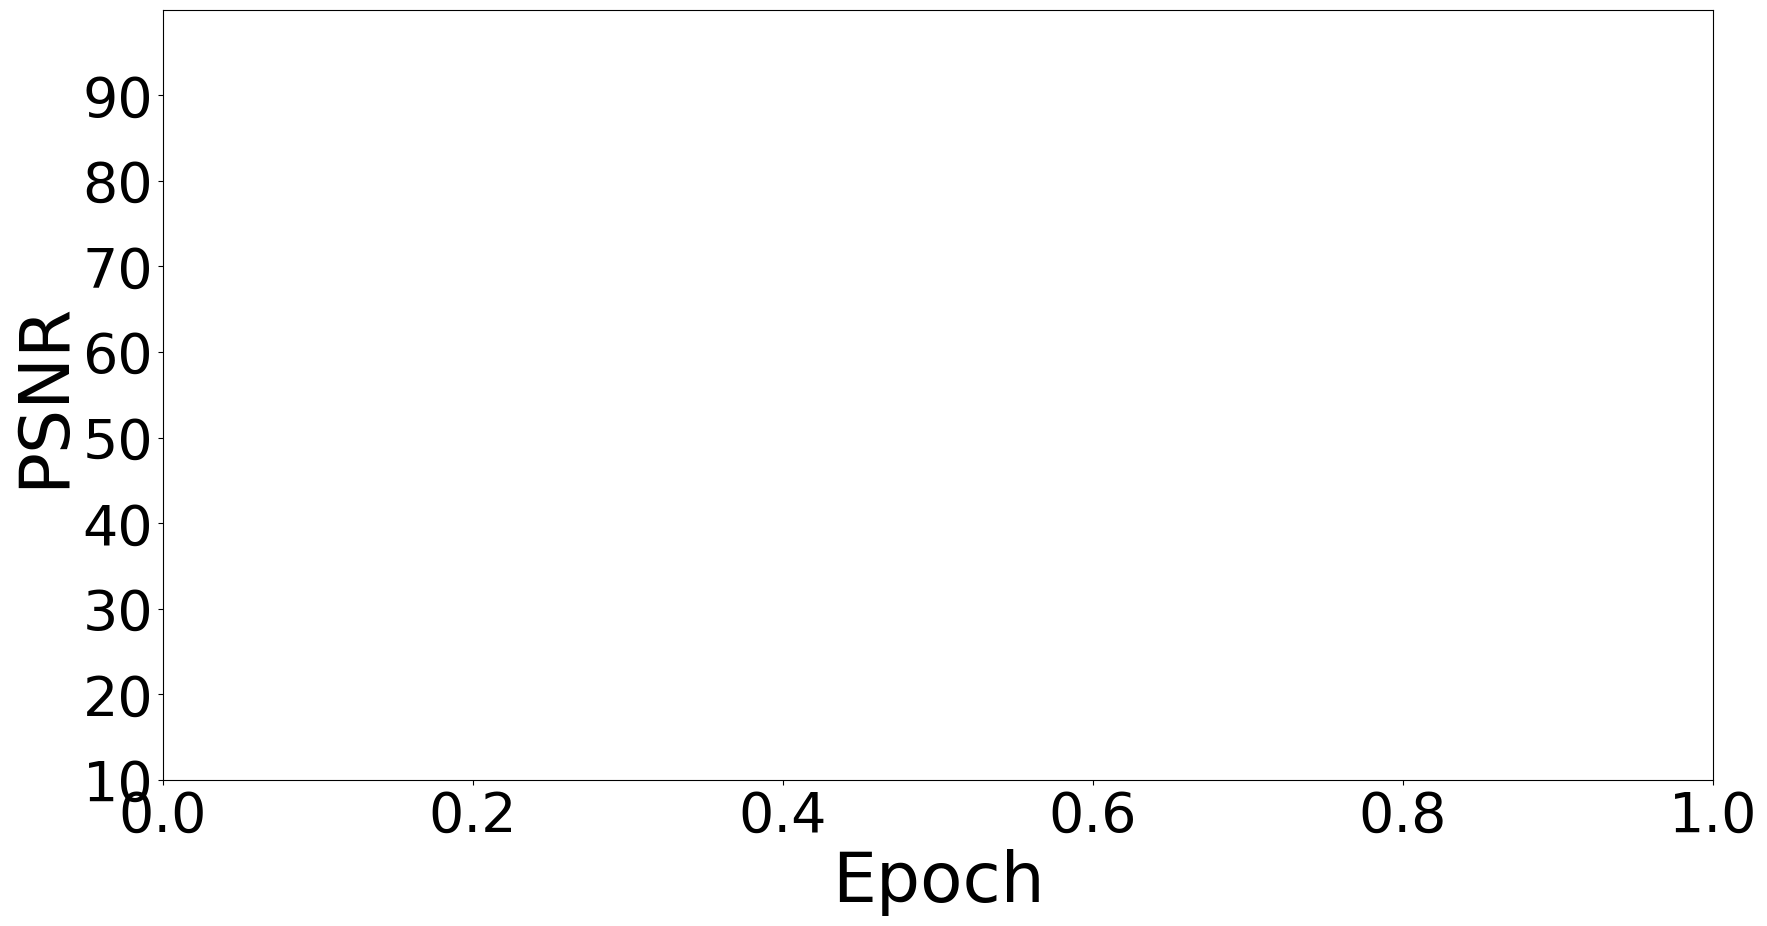

In [17]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('PSNR',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,100 , 10.0),fontsize=40)
plt.ylim(10,100)
plt.plot(x,linewidth=5.0)
plt.savefig('PSNR-IN.pdf')
plt.show()



In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('SSIM',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xx,linewidth=5.0)
plt.savefig('SSIM-IN.pdf')

plt.show()


In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 Reconstruction loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-IN.pdf')
plt.show()



In [ ]:
from scipy.stats import entropy

In [ ]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20  
  info_div = 0  
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [ ]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [ ]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [ ]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    





In [ ]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    



In [ ]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    


In [ ]:
MSA(bsnlist)
MSD(bsnlist)
EntropySum(bsnlist)

In [ ]:
dabs = [ 33.12881252113703 , 27.699269748852547 , 31.189050523240567 , 25.407158521806743 , 21.23842365661258 , 21.4600299169822 , 20.86248085946583 , 20.17228040657472 , 20.53299041484558 , 21.1335634998955 , 19.59117061832842 , 20.946230004039375 , 22.843494279707382 , 21.596483466175062 , 21.633130554147392 , 22.832050045391185 , 23.112561570936894 , 23.938250673675114 , 24.27697303727743 , 24.67049003424132 , 24.818116958133697 , 24.450204537801287 , 25.019421764795172 ]
bsnetconv = [ 24.926582298710684 , 21.330938461786815 , 23.04076040826106 , 21.645181998356264 , 18.691557180047244 , 20.7226257192415 , 20.180950404677475 , 18.92119239091796 , 18.14126793229048 , 18.054941145300337 , 19.2913419518319 , 21.458442690479096 , 22.376986846120094 , 26.539316782854403 , 26.364677531292276 , 26.004356791026886 , 26.06563007931373 , 27.562615680165703 , 26.816233958923476 , 26.75423730463073 , 26.76546728344344 , 26.651876628889074 , 26.170407693767313 ]
pca = [ 64.6659495569616 , 44.206964175291155 , 56.974405048963185 , 47.303760042785385 , 39.8940534876976 , 34.768743086455515 , 30.563590015282664 , 27.347606401064958 , 25.73579551531729 , 23.562059922897653 , 24.332531206971105 , 22.65318676880641 , 21.20680313199034 , 19.950365482269632 , 18.7957381872366 , 17.785780071254095 , 16.84197341100759 , 16.71704973304585 , 15.959359012341034 , 16.69296720295007 , 16.303398054778945 , 15.775575036839665 , 15.247189808858215 ]
spabs = [ 51.546751478947485 , 41.56190968855882 , 34.1507585379382 , 32.18755647433454 , 31.393008047463585 , 31.02527459658134 , 30.212480943960397 , 33.42180148091237 , 32.627589457381625 , 30.811290451152864 , 31.07497311582388 , 29.193101794721112 , 28.174085856682574 , 27.110556610241026 , 26.16396012024104 , 27.642474793195948 , 26.97927639524588 , 26.802185442574 , 26.733570979934218 , 25.614498829087168 , 24.57496106936372 , 24.260774948635653 , 24.535411090068447 ]
snmf = [ 42.687271482734026 , 69.98650272134581 , 65.56190884814379 , 64.78830503377719 , 60.283392581094056 , 57.29725635316855 , 61.48424023193987 , 65.9111624844873 , 69.81263992889625 , 66.0216268025207 , 63.44659867282022 , 59.12927876180595 , 55.89468878602123 , 54.131703617998376 , 56.680276749080825 , 59.53217131059314 , 57.16351130033321 , 54.9461367723193 , 55.23628180002861 , 54.62510055278423 , 53.74485500301176 , 52.97448803455957 , 51.9084356071723 ]
issc = [ 18.282704191681795 , 35.29174781838125 , 33.52621667208111 , 34.7570094214297 , 34.693446545983406 , 33.8470987598166 , 42.36183874938314 , 38.34479910743488 , 38.34974051412382 , 35.28287700260462 , 32.65494379097696 , 32.312139823186655 , 30.307662525527835 , 29.98966839606608 , 29.269512799967384 , 29.912423244699333 , 29.038917745855983 , 28.929037072912795 , 28.672306590798843 , 28.505889476998565 , 28.182865736586837 , 28.759689061354372 , 28.95934175252772 ]
new = [ 0.3815454878000646 , 6.781090755133797 , 9.950440828878444 , 11.237053937027174 , 27.088203156192495 , 28.32426713263673 , 31.61098768365176 , 29.18215151414016 , 30.623415605281778 , 28.31521833089382 , 27.449306705475106 , 26.808790797203535 , 26.64422017203365 , 26.15949242450031 , 24.537110949551423 , 26.60549266437586 , 25.726471570464867 , 25.336850074623072 , 24.637817130631845 , 23.95399234128613 , 23.29746143739684 , 22.647506727415077 , 22.878749722275444 ]
NSBands = list((i for i in range(2,25)))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
methods = [dabs,bsnetconv,pca,spabs,snmf,new]
for i in methods:  print(len(i))
markerstylelist = ["8","1","2","4","*","3","5"]
scatar = []
f = plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
for method in methods:
  PLOT = plt.plot(NSBands,method,markersize=30)
  SCATTER = plt.scatter(NSBands,method,s=100)
  scatar.append(SCATTER)
plt.xlabel('Number of Selected Bands',fontsize=40)
plt.ylabel('MSD',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(1,80)
plt.xlim(1,25)
plt.legend(scatar,['DARecNet-BS','BSNet-Conv','PCA','SpaBS','SNMF','New'],loc='best',fontsize='xx-large',shadow=True,prop={'size': 26},bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.show()
f.savefig("MSD-IN.pdf", bbox_inches='tight')